Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [81]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import read_data as rd

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [19]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

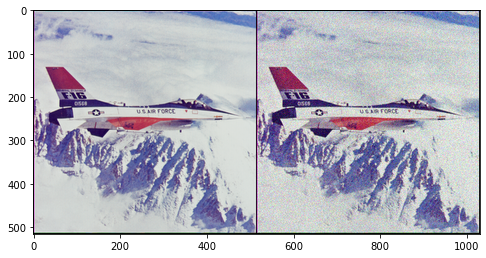

In [20]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [82]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 2000
input_depth = 1
figsize = 5 
    
net = skip(
                input_depth, input_depth, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU'
)

net = net.type(dtype)
    
# net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

# img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 572665


In [83]:
f_n = './data/dtu15_gtim5_do0280_rr0004.dat'
gmdt, d = rd.reshape_data(f_n)
nan_mask = np.ones_like(gmdt)
nan_mask[np.isnan(gmdt)] = 0
nan_mask = nan_mask.astype('bool')

gmdt[np.isnan(gmdt)] = 0 # np.nanmin(gmdt)
orig_min = np.min(gmdt)
orig_spread = np.max(gmdt)-np.min(gmdt)
gmdt = (gmdt - np.min(gmdt)) / (np.max(gmdt) - np.min(gmdt))
print(np.any(np.isnan(gmdt)))


nan_mask_smoothed = np_to_torch(nan_mask.copy()).type(dtype)
mask_input = nan_mask_smoothed.unsqueeze(0)
img_noisy_torch = np_to_torch(gmdt).type(dtype)
img_noisy_torch = img_noisy_torch.unsqueeze(0)
net_input = img_noisy_torch
print(np.any(np.isnan(net_input.cpu().numpy())))

False
False


# Optimize

Starting optimization with ADAM


c:\users\oa18724\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


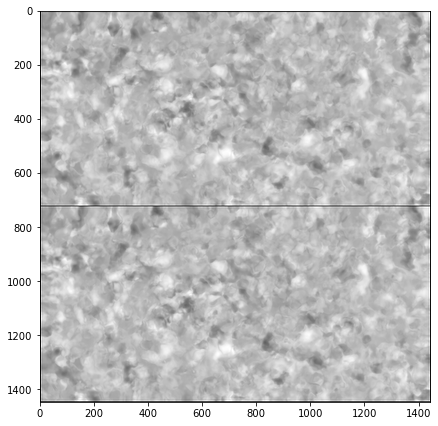

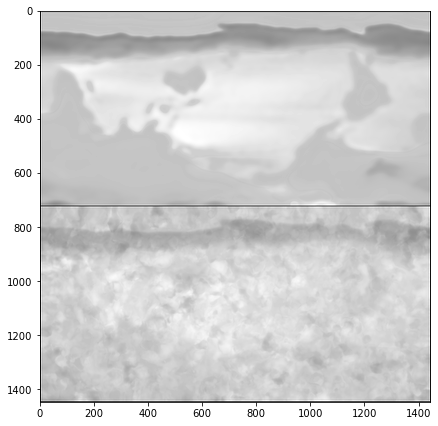

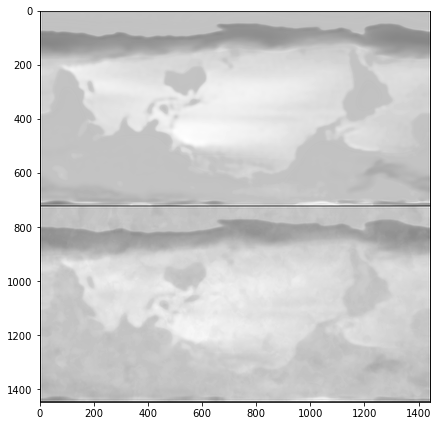

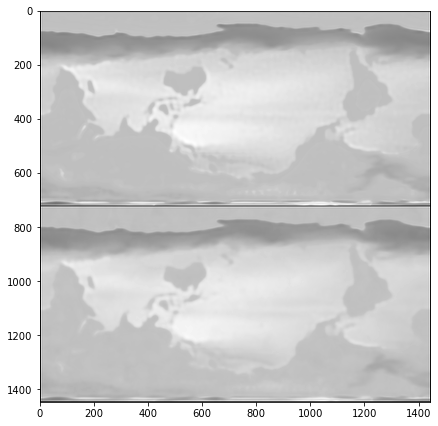

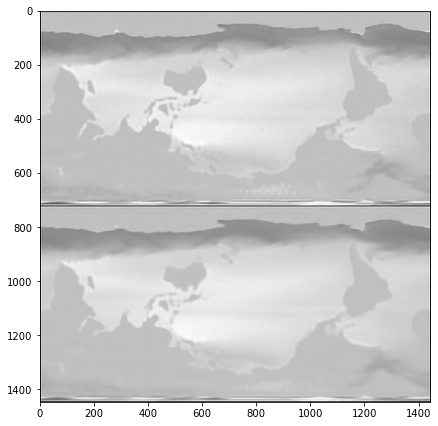

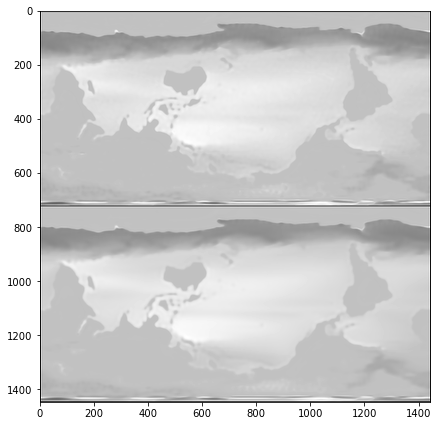

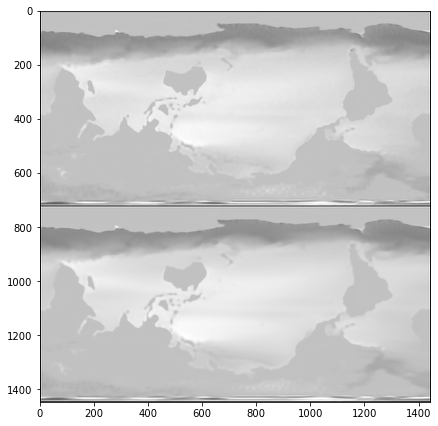

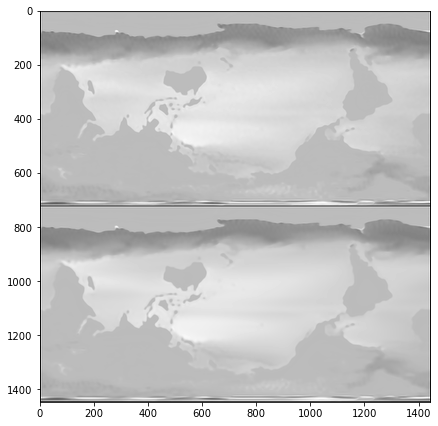

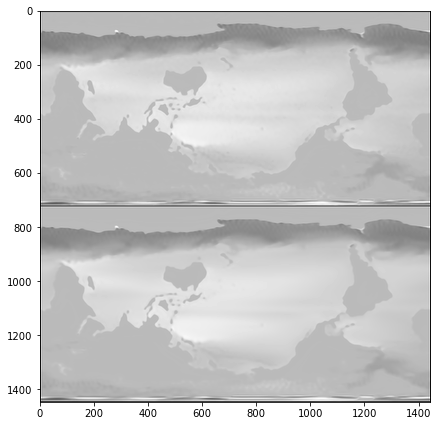

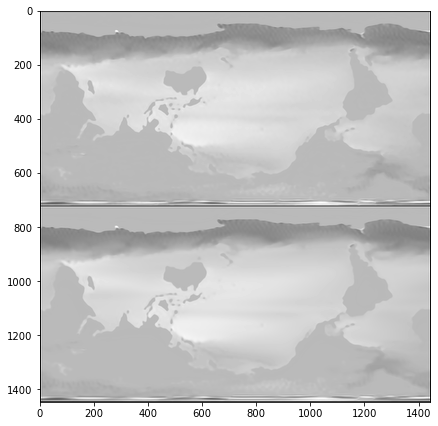

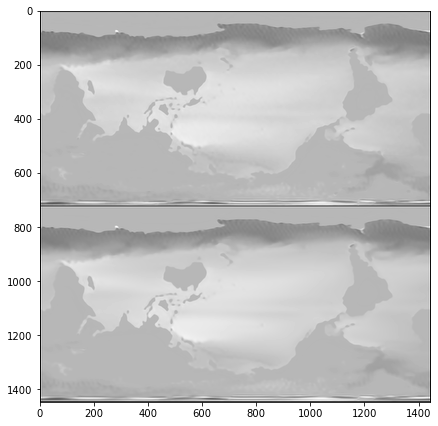

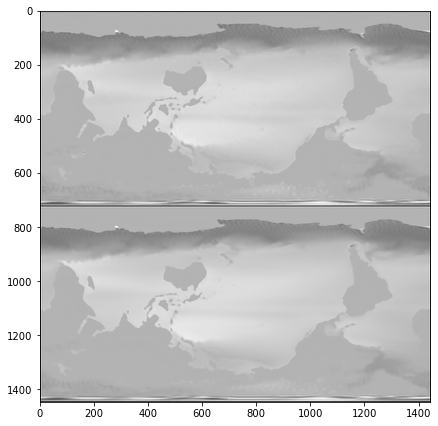

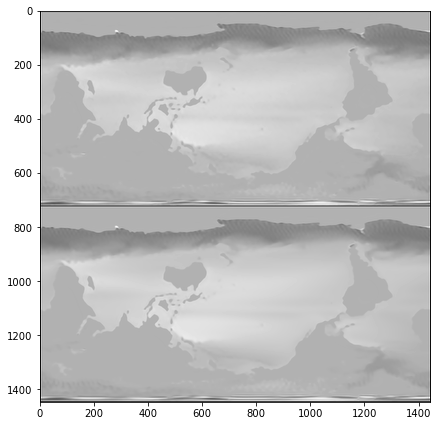

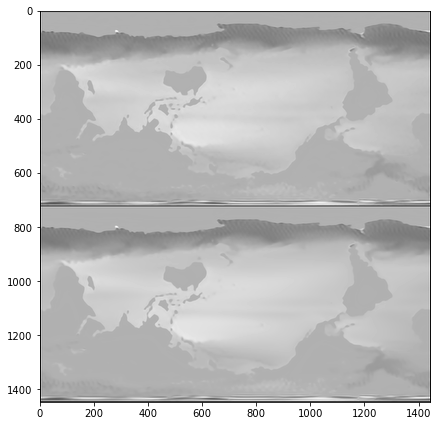

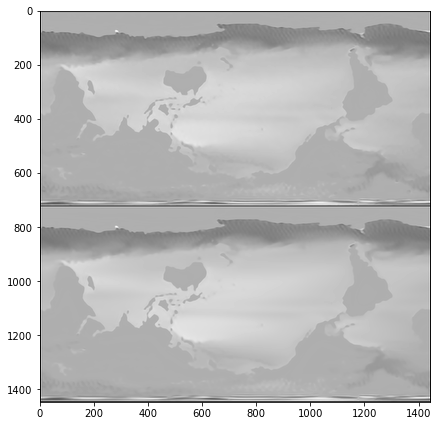

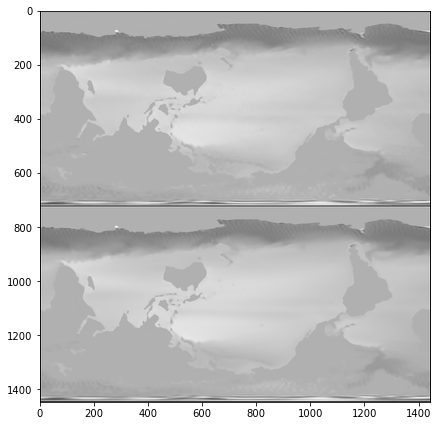

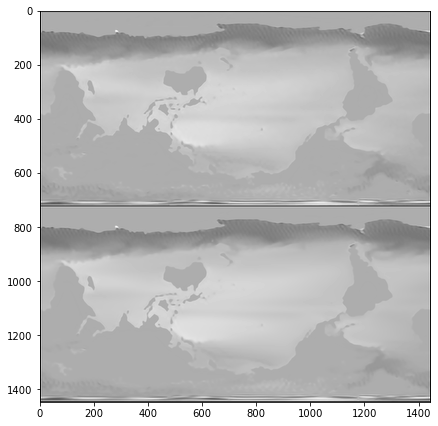

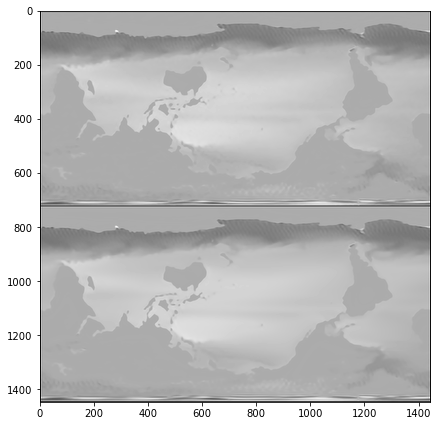

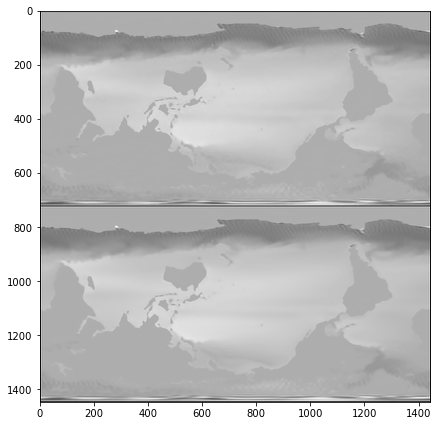

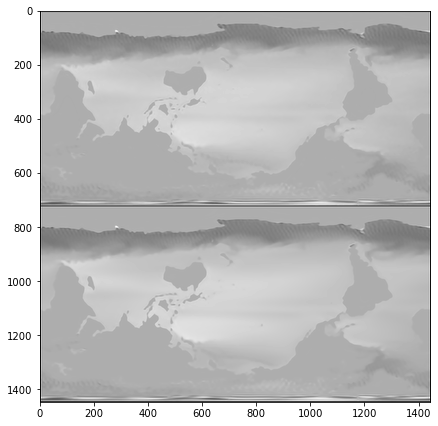

In [84]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
        
    np_out = out.detach().cpu().squeeze(0)
    psrn_noisy = compare_psnr(gmdt, np_out.numpy()[0]) 
    # psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    # psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f' % (i, total_loss.item(), psrn_noisy), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

(720, 1440)


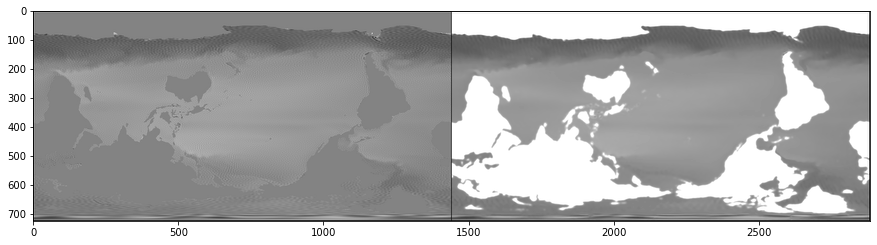

In [105]:
from scipy.ndimage import gaussian_filter
out_np = torch_to_np(net(net_input))
out_mask = gaussian_filter(torch_to_np(mask_input), sigma=3)
#out_mask = torch_to_np(net(mask_input))

out = out_np / (out_mask + 1e-12) # smooth0mask
#out = out_np  # smoothnomask


print(gmdt.shape)
# np.clip(out_mask, 0, 1)
# np.expand_dims(gmdt, 0)
q = plot_image_grid([np.expand_dims(gmdt, 0), np.clip(out, 0, 1)], factor=13);

In [106]:
print(np.max(gmdt), np.max(gmdt_out))
print(np.any(np.isnan(gmdt_out)))
gmdt_out = (out*orig_spread)+orig_min
gmdt_out = gmdt_out * nan_mask
print(np.any(np.isnan(gmdt_out)))
print(np.max(gmdt), np.max(gmdt_out))
gmdt_out = np.squeeze(gmdt_out, 0)
gmdt_out[np.logical_not(nan_mask)] = np.nan
rd.write_dat(gmdt_out, 'dip_smooth0mask_2000_dtu15gtim5do0280_rr0004.dat', overwrite=True)

1.0 nan
True
False
1.0 39.818962


True